_This notebook was put together by [Keneth Garcia](https://stivengarcia7113.wixsite.com/kenethgarcia). Source and license info are on [GitHub](https://github.com/KenethGarcia/GRB_ML)._

# Swift Data Noise Reduction
The Neil Gehrels Swift Observatory presents analysis results for the Swift/BAT Gamma-Ray Burst (GRBs) on [this website](https://swift.gsfc.nasa.gov/results/batgrbcat/) (open access).

Swift/BAT data are **particularly noisy**, and taking more cleaned light curves for t-SNE can refine its results. This notebook summarizes how to reduce noise from Swift Data using non-parametric noise reduction technique implemented on [FABADA](https://github.com/PabloMSanAla/fabada). Through this document, we are using the _python3_ implementations from the _ClassiPyGRB_ package. It is necessary to have an internet connection and a _Jupyter Notebook_/_Python 3_ compiler software.

First, we need to import the _SWIFT_ instance of _ClassiPyGRB_ to our notebook (and some other packages needed in this notebook):

In [1]:
from ClassiPyGRB import SWIFT
# Importing other packages needed
import os
import pandas as pd

## Changing the Swift GRB binning
By default, the following sections reduces noise in Swift/BAT data at 64ms binning. There are some cases in which we need to use different data resolutions and binning; handling these situations can be solved in this package by managing the _resolution_ $res$ argument.

Through **ClassiPyGRB**, you can change the _resolution_ variable to $2$, $8$, $16$, $64$, and $256$ ms respectively. Additionally, you can set $res=1000$ for 1s binning and $res=10000$ to use data with a signal-to-noise ratio higher than 5 or 10 s binning (10s data don't have uniform time spacing).

In **ClassiPyGRB** you have a high-level of saving data customization. You can set the following paths:
- $root\_path$ (str): Main path to save data/results from SWIFT. Unique mandatory path to ensure the functionality of SWIFT Class.
- $original\_data\_path$ (str, optional): Path to save non-manipulated data from SWIFT. Defaults to Original\_Data folder inside data\_path.
- $noise\_data\_path$ (str, optional): Path to save noise-reduced data from SWIFT. Defaults to Noise\_Filtered\_Data folder inside data\_path.
- $results\_path$ (str, optional): Path to save non-manipulated data from SWIFT. Defaults to Results folder inside root\_path.
- $noise\_images\_path$ (str, optional): Path to save noise-reduced plots from SWIFT. Defaults to Noise\_Filter\_Images folder inside results\_path.
- $table\_path$ (str, optional): Path to save tables from SWIFT. Defaults to Tables folder inside root\_path.

Moreover, in **ClassiPyGRB** you can customize the bands used from Swift/BAT data using the parameter `n_bands`. This parameter consist in an array of integers ranging from 1 to 5, where each integer represent a unique band from Swift. In order, 1 represent the 15-25 keV band, 2 represent the 25-50 keV band, 3 represent the 50-100 keV band, 4 represent the 100-350 keV band, and 5 represent the 15-350 keV band. Therefore, as example, by using $n\_bands=[2, 4]$ **ClassiPyGRB** understands that you want to work with 25-50 keV and 100-350 keV bands. Setting `n_bands` in an appropriate way can help you to improve time of preprocess, results of t-SNE and custom plotting from Swift/BAT.

At this point, the most simple and easy implementation of **ClassiPyGRB** only uses $root\_path$ as a main folder and saves both data and results in this path:


In [2]:
swift = SWIFT(root_path=r'/media/keneth/2B2E62755DA79CD3/Swift_Test', res=64)
print(f"Swift/BAT bands selected: {swift.bands_selected}")

Swift/BAT bands selected: ['Time(s)', '15-25keV', '25-50keV', '50-100keV', '100-350keV']


Last, extract the GRB Names of Swift, and remove the GRBs with download errors, only if you already have downloaded data form Swift/BAT:

In [3]:
df = swift.summary_table()
GRB_names = df['GRBname'] # GRB Names total array
try:
    df = pd.read_table(os.path.join(swift.original_data_path, f"Errors_{swift.end}.txt"), sep='\t', comment='#', names=['GRB Name', 'Error'], header=None)
    GRB_errors = df['GRB Name']
except FileNotFoundError:
    pass
else:
    GRB_names = GRB_names[~GRB_names.isin(GRB_errors)]
print(f'There are {len(GRB_names)} GRBs in the current working Swift/BAT dataset.')

There are 1505 GRBs in the current working Swift/BAT dataset.


**Note:** If you haven't downloaded the data yet, check the _BAT_Data_Download_ notebook. It is strongly recommended to download data before to run this notebook, although the instances used here can work without any previous downloaded data, the time of execution can be highly affected if you do not have it.

## Fully Adaptive Bayesian Algorithm for Data Analysis - FABADA

Taked from their [GitHub](https://github.com/PabloMSanAla/fabada):
_FABADA is a novel non-parametric noise reduction technique which arise from the point of view of Bayesian inference that iteratively evaluates possible smoothed models of the data, obtaining an estimation of the underlying signal that is statistically compatible with the noisy measurements. (...) **The only requisite of the input data is an estimation of its associated variance**._

As you can read, we need to estimate variance prior to implementing FABADA. To do this, we use a public method based on _[John Immerkær(1996)](https://www.semanticscholar.org/paper/Fast-Noise-Variance-Estimation-Immerk%C3%A6r/1da5c5819ae1d33a2a4acc57e16cb655374054e7)_; it consists of a simple function that takes one light curve band array as a 1 pixel gray-scaled image. To prevent disturbing estimation by the GRB itself, we use only the data outside $T_{100}$.

Let's reduce the noise of a specific GRB:

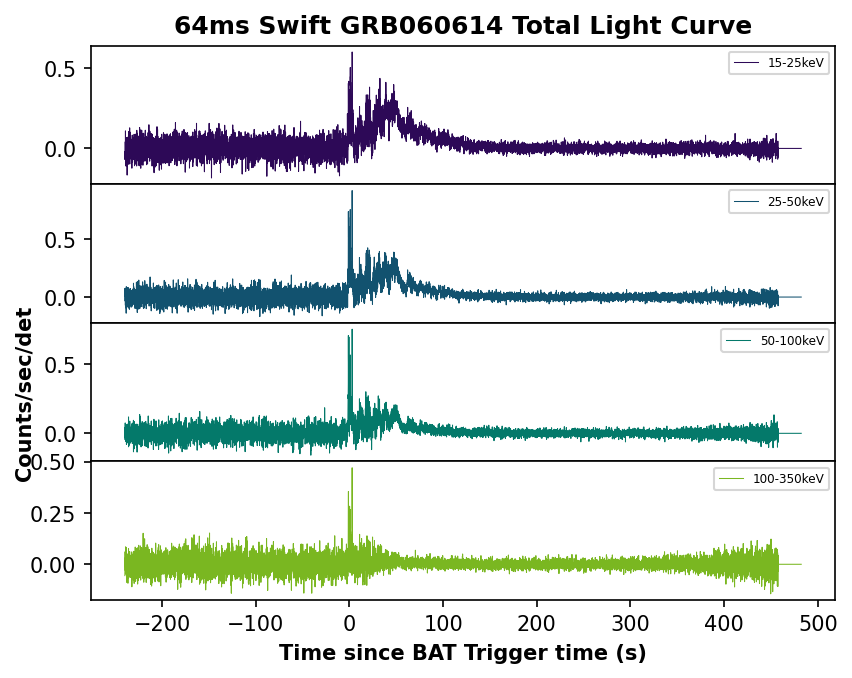

In [4]:
name = 'GRB060614'
ax = swift.plot_any_grb(name=name)

Through the `noise_reduction_fabada` instance, we can reduce the noise of any GRB in the dataset only by introducing its name:

In [5]:
df = swift.noise_reduction_fabada(name=name)
print(df)

       Time(s)      15-25keV  15-25Err      25-50keV  25-50Err     50-100keV  \
0     -239.728 -7.557219e-03  0.052361  4.795231e-03  0.050291  9.318385e-03   
1     -239.664 -7.769840e-03  0.057223  5.478403e-03  0.048346  9.386921e-03   
2     -239.600 -7.879099e-03  0.047978  4.923547e-03  0.048173  9.803430e-03   
3     -239.536 -6.809064e-03  0.042630  4.779939e-03  0.041823  9.945709e-03   
4     -239.472 -5.939465e-03  0.039029  4.457471e-03  0.042034  9.689766e-03   
...        ...           ...       ...           ...       ...           ...   
11277  482.000 -2.437139e-23  0.000000 -8.913424e-23  0.000000 -4.749593e-23   
11278  482.064 -2.140248e-23  0.000000 -7.847584e-23  0.000000 -4.170556e-23   
11279  482.128 -1.933059e-23  0.000000 -7.103025e-23  0.000000 -3.766461e-23   
11280  482.192 -1.807234e-23  0.000000 -6.650537e-23  0.000000 -3.521053e-23   
11281  482.256 -1.757703e-23  0.000000 -6.472345e-23  0.000000 -3.424448e-23   

       50-100Err    100-350keV  100-350

Additionally, you can control the results of noise reduction by specifying the variance to use in the FABADA algorithm setting the `sigma` argument. It can receive a constant variance value or a list of variance values for each band. If you don't specify any value, the variance will be estimated using the RMS noise of an image.

Moreover, you can save the results of noise reduction in a table by setting the `save` argument to `True`. By default, the table will be saved in the `noise_data_path` folder with the name `{GRB Name}_{end}.h5`. You can change the path of saving by setting the `noise_data_path` argument in `SWIFT` instance.

Let's plot the results of noise reduction using the `plot_any_grb` instance:

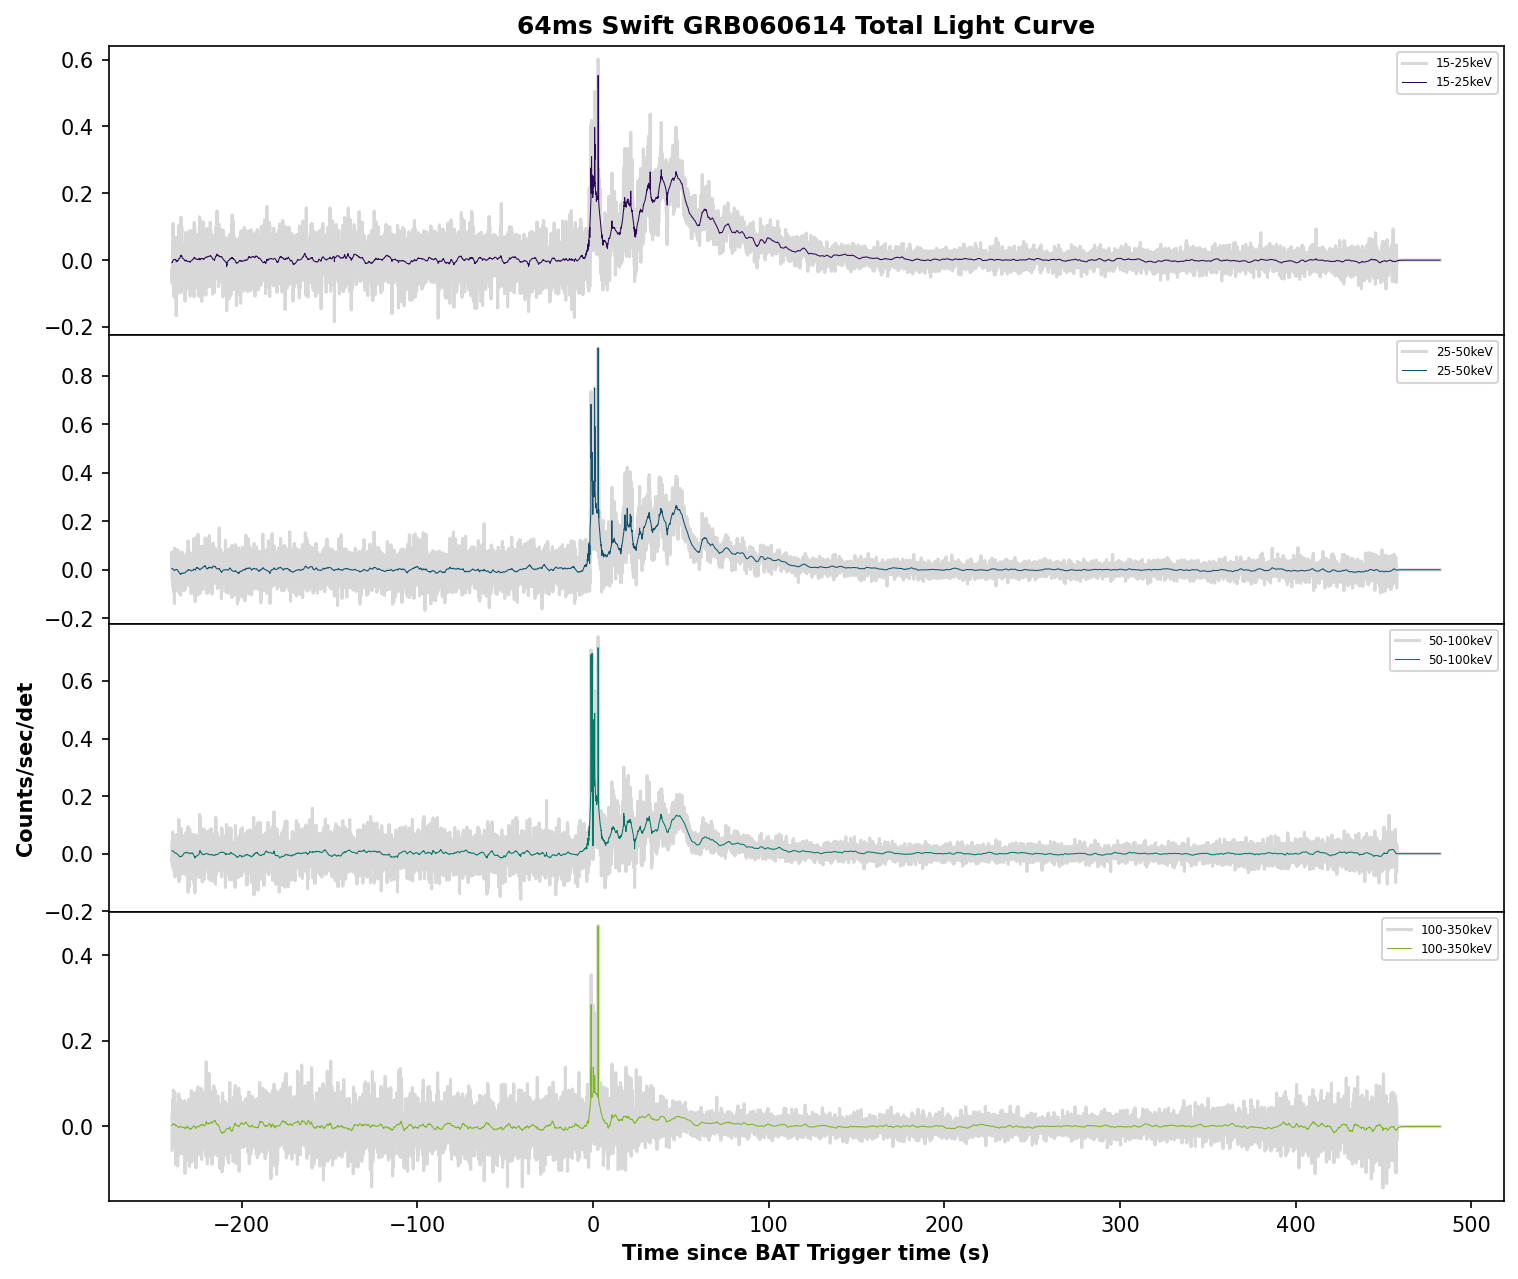

In [6]:
swift.noise_reduction_fabada(name=name, save_data=True)  # Save the results of noise reduction in disk
ax2 = swift.plot_any_grb(name=name, kind='Interpolated', legend=False, figsize=[12, 10])  # Plot original data
# Change temporary the path where plot_any_grb method looks for data
old_path = swift.original_data_path
swift.original_data_path = swift.noise_data_path
ax2 = swift.plot_any_grb(name=name, legend=True, ax=ax2, check_disk=True)  # Force to read data from disk
swift.original_data_path = old_path

and inside $T_{100}$:

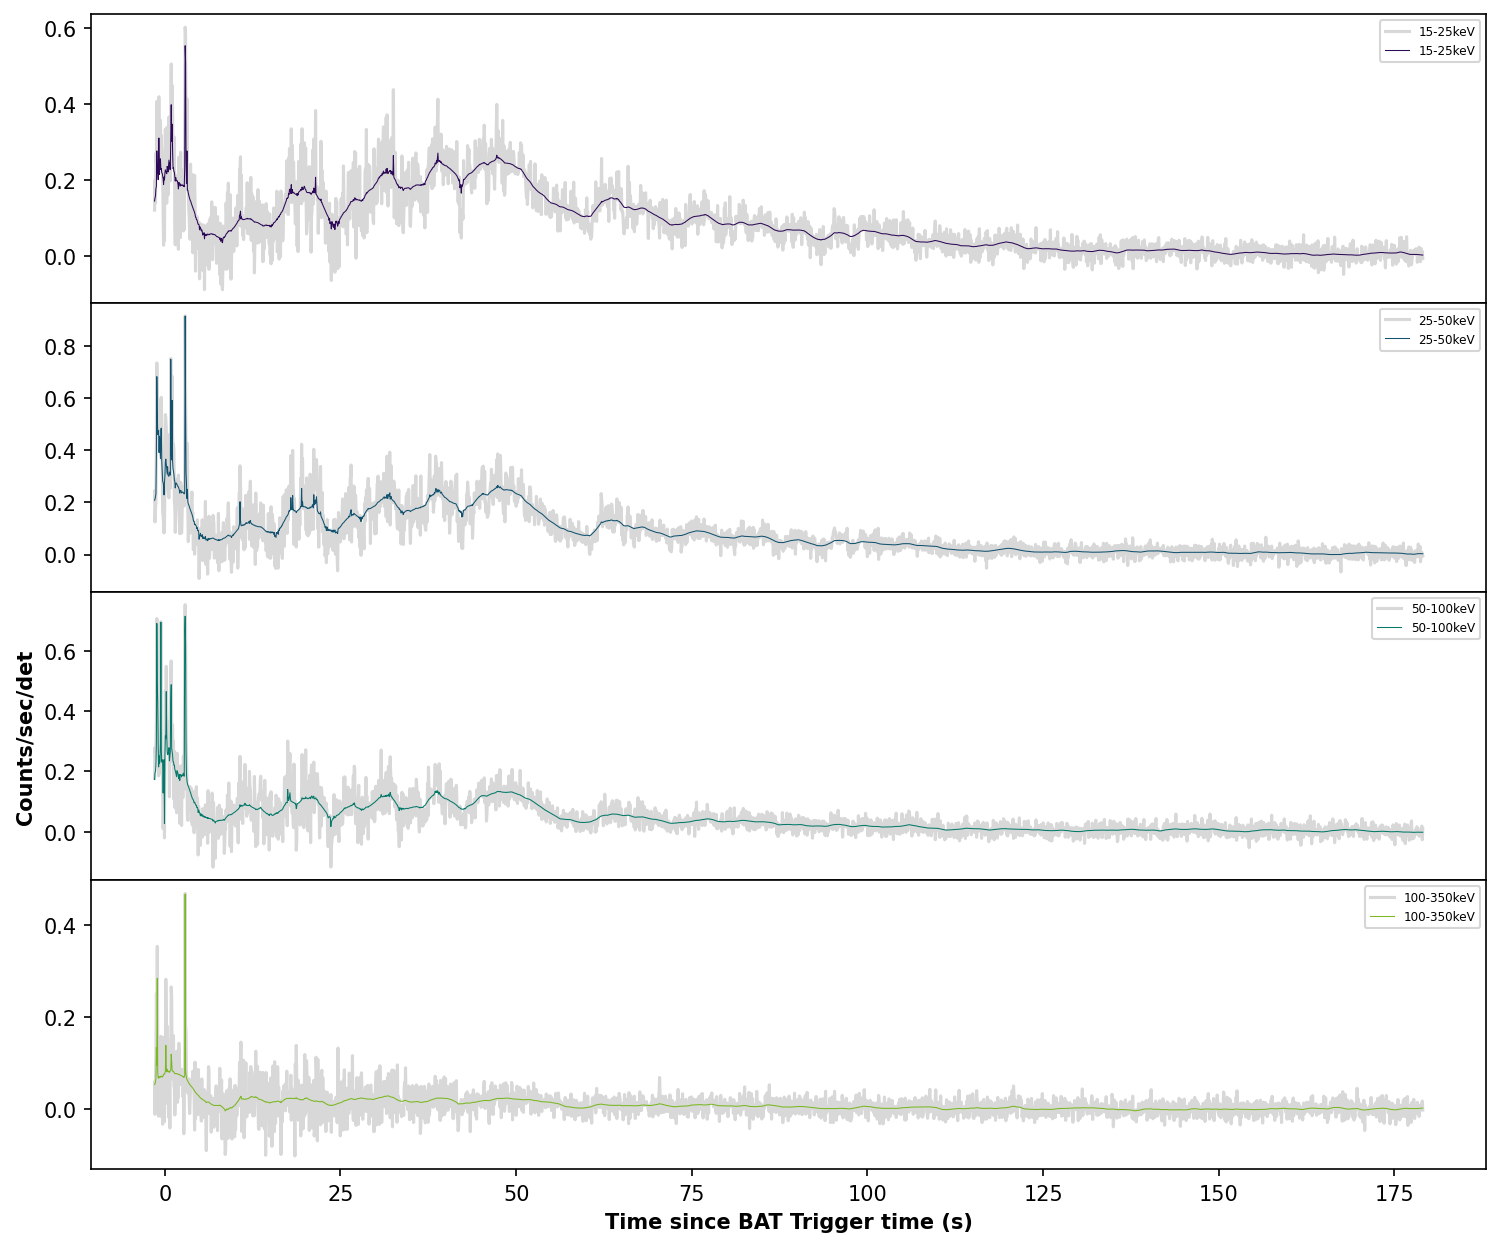

In [7]:
ax3 = swift.plot_any_grb(name=name, kind='Interpolated', legend=False, t=100, figsize=[12, 10])  # Plot original data
# Change temporary the path where plot_any_grb method looks for data
old_path = swift.original_data_path
swift.original_data_path = swift.noise_data_path
ax3 = swift.plot_any_grb(name=name, legend=True, ax=ax3, t=100, check_disk=True)  # Force to read data from disk
swift.original_data_path = old_path

As you can see, the gray background represents the original data, and colored lines the noise filtered results (the plot is saved automatically in the results' directory). In general, the noise reduction is satisfactory and reveals a problem: GRBs with low signal-to-noise ratios seem like only random noise. Check (for example) the GRB060203 results:

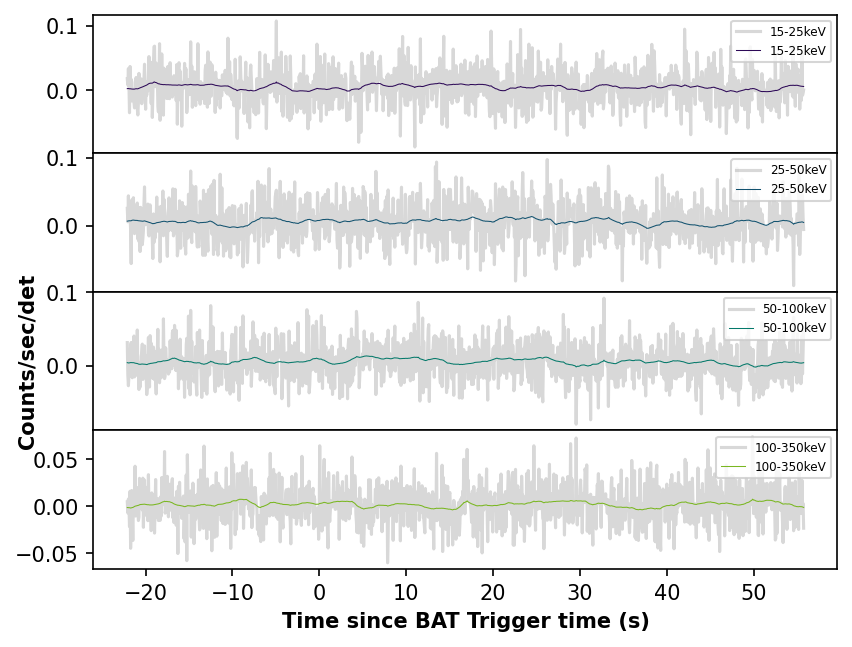

In [8]:
df2 = swift.noise_reduction_fabada(name='GRB060203', save_data=True)
ax4 = swift.plot_any_grb(name='GRB060203', kind='Interpolated', legend=False, t=100)
old_path = swift.original_data_path
swift.original_data_path = swift.noise_data_path
ax4 = swift.plot_any_grb(name='GRB060203', legend=True, ax=ax4, t=100, check_disk=True)
swift.original_data_path = old_path

Beyond this fact, we can parallelize the noise reduction using the `parallel_noise_reduction_fabada` instance (enable the `save_data` parameter to keep results in the data directory):

In [9]:
df_list = swift.parallel_noise_reduction_fabada(names=GRB_names, save_data=True)
del df_list, df, ax2, ax3, ax4, old_path

Noise reduction:   9%|▉         | 133/1505 [01:10<17:04,  1.34GRB/s]/home/keneth/Documents/ClassiPyGRB/ClassiPyGRB/_swift.py:1068: RuntimeWarning: Error when obtaining limits for GRB200324A: could not convert string to float: ''. Returning data without noise reduction.
  warnings.warn(f"Error when obtaining limits for {name}: {err}. Returning data without noise reduction.",
Noise reduction:  21%|██        | 309/1505 [02:29<10:01,  1.99GRB/s]/home/keneth/Documents/ClassiPyGRB/ClassiPyGRB/_swift.py:1091: RuntimeWarning: No data outside T_100 found for GRB180103A.
  warnings.warn(f"No data outside T_100 found for {name}.", RuntimeWarning)
Noise reduction:  22%|██▏       | 325/1505 [02:36<06:51,  2.87GRB/s]/home/keneth/Documents/ClassiPyGRB/ClassiPyGRB/_swift.py:1091: RuntimeWarning: No data outside T_100 found for GRB171010B.
  warnings.warn(f"No data outside T_100 found for {name}.", RuntimeWarning)
Noise reduction:  24%|██▎       | 354/1505 [02:52<12:42,  1.51GRB/s]/home/keneth/Document

## Pre-processing procedure
With the noise-filtered data, we need to pre-process it to use on t-SNE. The main idea is to change the _original_data_path_ to the noise filtered data path and follows the same methods from the [_3.BAT_Preprocess_](https://github.com/KenethGarcia/ClassiPyGRB/blob/8546f224e3b722a73440a1341270b271cbfdfeb5/docs/3.BAT_Preprocess.ipynb) notebook:

In [17]:
old_path = swift.original_data_path
swift.original_data_path = swift.noise_data_path
limited_data, GRB_names2, errors = swift.parallel_lc_limiter(GRB_names)
print(errors)

LC limiting: 100%|██████████| 1505/1505 [00:55<00:00, 26.97GRB/s] 


        Names t_start  t_end       Error
0  GRB210119A     0.0   0.08    Length=1
0  GRB200324A                 ValueError
0  GRB190326A     0.0  0.104    Length=1
0  GRB180718A     0.0    0.1    Length=1
0  GRB170906B -11.776  7.424    Length=0
0  GRB170524A     0.0   0.12    Length=2
0  GRB170112A  -0.004  0.056    Length=1
0  GRB161104A  -0.016    0.1    Length=1
0  GRB160601A  -0.024   0.12    Length=2
0  GRB160525A                 ValueError
0  GRB160501A                 ValueError
0  GRB151107A                 ValueError
0  GRB150710B                 ValueError
0  GRB150424A                 IndexError
0  GRB150101B     0.0  0.016    Length=1
0  GRB150101A     0.0  0.068    Length=1
0  GRB141102A     0.0   14.4  Only zeros
0  GRB140622A  -0.024  0.128    Length=2
0  GRB140311B                 ValueError
0  GRB130822A  -0.004  0.044    Length=0
0  GRB130305A     0.0   57.6  Only zeros
0  GRB120305A     0.0  0.128    Length=2
0  GRB120218A -26.696  8.312  Only zeros
0  GRB110420B  -

Normalize data:

In [18]:
normalized_data = swift.parallel_lc_normalize(limited_data)  # Normalizing all light curves
del limited_data  # Delete unused variable

LC Normalizing: 100%|██████████| 1455/1455 [00:00<00:00, 2027.15GRB/s]


Zero-pad:

In [19]:
zero_padded_data = swift.parallel_zero_pad(normalized_data)
del normalized_data  # Delete unused variable

LC Zero-Padding: 100%|██████████| 1455/1455 [00:01<00:00, 1104.38GRB/s]


Concatenate data:

In [20]:
concatenated_data = swift.parallel_concatenate(zero_padded_data)  # Concatenate data without DFT

Concatenating: 100%|██████████| 1455/1455 [00:01<00:00, 1019.80GRB/s]


Perform DFT:

In [21]:
pre_processing_data = swift.parallel_dft_spectrum(zero_padded_data)

Performing DFT: 100%|██████████| 1455/1455 [00:01<00:00, 1319.75GRB/s]


Finally, save the results:

In [22]:
swift.save_results(f'SWIFT_Noise_Reduced_data_{swift.res}res_{"".join(str(b) for b in swift.n_bands)}bands_DFT_True.npz', names=GRB_names, data=pre_processing_data)  # Save Data with DFT
swift.save_results(f'SWIFT_Noise_Reduced_data_data_{swift.res}res_{"".join(str(b) for b in swift.n_bands)}bands_DFT_False.npz', names=GRB_names, data=concatenated_data)  # Save Data without DFT